In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
%matplotlib inline

In [2]:
data = np.loadtxt('./wine.data.txt', delimiter=',')
featurenames = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash','Magnesium', 'Total phenols', 
                'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 
                'OD280/OD315 of diluted wines', 'Proline']

In [3]:
print(data.shape[0], data.shape[1])

whole_size = data.shape[0]
train_size = 130
feature_size = data.shape[1]

np.random.seed(0)
perm = np.random.permutation(whole_size)
trainx = data[perm[0:train_size], 1:feature_size]
trainy = data[perm[0:130],0]
testx = data[perm[train_size:],1:feature_size]
testy = data[perm[train_size:], 0]

178 14


In [4]:
print(trainx.shape, trainy.shape, testx.shape, testy.shape)

(130, 13) (130,) (48, 13) (48,)


In [5]:
sum(trainy==1), sum(trainy==2), sum(trainy==3)

(43, 54, 33)

## Question: there are class 1: 43, class 2: 54, class 3: 33

(array([ 1.,  7.,  4.,  6.,  7.,  1., 10.,  5.,  0.,  2.]),
 array([12.85 , 13.048, 13.246, 13.444, 13.642, 13.84 , 14.038, 14.236,
        14.434, 14.632, 14.83 ]),
 <a list of 10 Patch objects>)

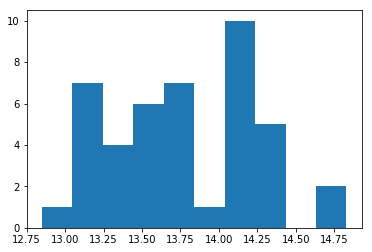

In [6]:
class1 = trainx[trainy==1]
plt.hist(class1[:,0])

In [7]:
@interact_manual(feature=IntSlider(0,0,12), label=IntSlider(1,1,3))
def density_plot(feature, label):
    plt.hist(trainx[trainy==label,feature], normed=True)
    mu = np.mean(trainx[trainy==label,feature])
    var = np.var(trainx[trainy==label,feature])
    std = np.sqrt(var)
    
    x_axis = np.linspace(mu-3*std, mu+3*std, 1000)
    plt.plot(x_axis, norm.pdf(x_axis,mu,std), 'r', lw=2)
    plt.title("Winery "+str(label))
    plt.xlabel(featurenames[feature], fontsize=14, color='red')
    plt.ylabel('Density', fontsize=14, color='red')
    plt.show()

interactive(children=(IntSlider(value=0, description='feature', max=12), IntSlider(value=1, description='label', max=3, min=1), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

In [8]:
std_feature = [np.std(trainx[trainy==1,i]) for i in range(0,13)]
print(std_feature)
ind_min = std_feature.index(min(std_feature))
ind_max = std_feature.index(max(std_feature))
print('min var is: ', ind_min, ' , ', featurenames[ind_min])
print('max var is: ', ind_max, ' , ', featurenames[ind_max])

[0.482962509196465, 0.6567567855698971, 0.19176727828566711, 2.45766535216538, 10.884019077609793, 0.3437341470851615, 0.3903964785857551, 0.05964288894974403, 0.45327436810974586, 1.2246337627607105, 0.11543320245628266, 0.3558463277565554, 220.10397267776506]
min var is:  7  ,  Nonflavanoid phenols
max var is:  12  ,  Proline


## for class 1, the min variance is feature=Nonflavanoid phenols, the max variance is feature = Proline

In [9]:
# define a function to fit Gaussian
def fit_generative_model(x,y,feature):
    k = 3
    mu = np.zeros(k+1)
    var = np.zeros(k+1)
    pi = np.zeros(k+1)
    for label in range(1,k+1):
        indices = (y==label)
        mu[label] = np.mean(x[indices, feature])
        var[label] = np.var(x[indices, feature])
        pi[label] = float(sum(indices))/float(len(y))
    return mu,var,pi

In [10]:
feature = 0 # 'alcohol'
mu, var, pi = fit_generative_model(trainx, trainy, feature)
print(pi[1:])

[0.33076923 0.41538462 0.25384615]


In [11]:
print(mu)
print(var)
print(pi)

[ 0.         13.78534884 12.31092593 13.15969697]
[0.         0.23325279 0.2819047  0.2851787 ]
[0.         0.33076923 0.41538462 0.25384615]


In [12]:
@interact_manual(feature=IntSlider(0,0,12))
def show_densities(feature):
    mu, var, pi = fit_generative_model(trainx, trainy, feature)
    colors = ['r', 'k', 'g']
    for label in range(1,4):
        m = mu[label]
        s = np.sqrt(var[label])
        x_axis = np.linspace(m-3*s, m+3*s, 1000)
        plt.plot(x_axis, norm.pdf(x_axis,m,s), colors[label-1], label="class "+str(label))
    plt.xlabel(featurenames[feature], fontsize=14, color='red')
    plt.ylabel('Density', fontsize=14, color='red')
    plt.legend()
    plt.show()

interactive(children=(IntSlider(value=0, description='feature', max=12), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

## which features do the denities for class 1 and 3 overlap the most: Ash(feature 2), 
## next is Magnesium (feature 4), 
## which feature is class 3 the most spread out relative to the other two classes: Color intensity
## (feature 9)
## which feature do the 3 classes seem the most separated: Flavanoids (feature 6)

In [19]:
## predict with only one label
test_error = np.zeros(len(featurenames))
@interact(feature = IntSlider(0,0,12))
def test_model(feature):
    mu, var, pi = fit_generative_model(trainx, trainy, feature)
    k = 3
    n_test = len(testy)
    score = np.zeros((n_test, k+1))
    for i in range(0, n_test):
        for label in range(1, k+1):
            score[i, label] = np.log(pi[label]) + \
            norm.logpdf(testx[i,feature], mu[label], np.sqrt(var[label]))
    predictions = np.argmax(score[:,1:4], axis=1) + 1
    errors = np.sum(predictions != testy)
    print("Test error using feature " + featurenames[feature] + ":" + str(errors) +
         "/" + str(n_test))
    test_error[feature] = errors

interactive(children=(IntSlider(value=0, description='feature', max=12), Output()), _dom_classes=('widget-interact',))

In [23]:
print(test_error)
print(type(test_error))
print(test_error.argsort())

[17. 23. 29. 23. 21. 16.  8. 23. 16. 10. 14. 19. 17.]
<class 'numpy.ndarray'>
[ 6  9 10  5  8  0 12 11  4  1  3  7  2]


## The best feature is: Flavanoids: error rate: 8/48

In [24]:
## training error
train_error = np.zeros(len(featurenames))
@interact(feature=IntSlider(0,0,12))
def train_model_error(feature):
    mu, var, pi = fit_generative_model(trainx, trainy, feature)
    k = 3
    n_train = len(trainy)
    score = np.zeros((n_train, k+1))
    for i in range(0, n_train):
        for label in range(1, k+1):
            score[i,label] = np.log(pi[label]) + \
            norm.logpdf(trainx[i,feature], mu[label], np.sqrt(var[label]))
    predictions = np.argmax(score[:,1:4], axis=1) + 1
    errors = np.sum(predictions != trainy)
    print("Train error using feature " + featurenames[feature] + ":" + str(errors) +
         "/" + str(n_train))
    train_error[feature] = errors

interactive(children=(IntSlider(value=0, description='feature', max=12), Output()), _dom_classes=('widget-interact',))

In [34]:
print(train_error)
#train_error = [44,49,66,68,61,46,27,55,60,38,48,47,35]
ind = train_error.argsort()
print(train_error.argsort())
print(ind)
print(type(ind), type(featurenames))

[44. 49. 66. 68. 61. 46. 27. 55. 60. 38. 48. 47. 35.]
[ 6 12  9  0  5 11 10  1  7  8  4  2  3]
[ 6 12  9  0  5 11 10  1  7  8  4  2  3]
<class 'numpy.ndarray'> <class 'list'>


In [48]:
print(featurenames[ind[0]])
print(ind[0:3])
print(featurenames[ind[0]],featurenames[ind[1]], featurenames[ind[2]])

Flavanoids
[ 6 12  9]
Flavanoids Proline Color intensity


## for lowest training error: feature 6, 12, 9: Flavanoids, Proline, Color intensity

In [51]:
ind = test_error.argsort()
print(ind)
print(featurenames[ind[0]], featurenames[ind[1]], featurenames[ind[2]])

[ 6  9 10  5  8  0 12 11  4  1  3  7  2]
Flavanoids Color intensity Hue


## for lowest test error, feature 6, 9, 10 : Flavanoids, Color intensity, Hue